# Tarea 2 - Clasificación

- Di Carlo, Martina
- Pastrana Analía
- Suárez Gilda

Clasificación
Utilizando un clasificador basado en árboles de decisión estime el error de
predicción a medida que varía la complejidad del árbol. Verifique dicha predicción
utilizando un conjunto de test. Compare el error de train del clasificador con el de
test. Realice la tarea con los conjuntos de datos: car.data y aug_train.csv (Human
resources data). Discuta los resultados obtenidos brevemente.
Tener en cuenta que la clase de sklearn DecisionTreeClassifier controla la
complejidad del árbol con el parámetro ccp_alpha. Recuerde explicar en las gráficas
como varía la complejidad respecto a ccp_alpha. ¿Cuándo se vuelve más complejo
el árbol ? Resuelva utilizando StratifiedKFold, cual es la diferencia con KFold? (5
pts.)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyprojroot import here

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
path_data = here() / 'Martu' / 'Maestria' / 'data_mining' / 'practico2' / 'Datos'
path_data

WindowsPath('C:/Users/dicarlom/Desktop/Martu/Maestria/data_mining/practico2/Datos')

## car.data

In [3]:
df_car = pd.read_csv(path_data / 'car.data',
                    header=None,
                     names = ['buying','maint', 'doors', 'people', 'lug_boot', 'safety','target'])
df_car.head()

,buying,maint,doors,people,lug_boot,safety,target
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc



```
Attribute Values:

   buying       v-high, high, med, low
   maint        v-high, high, med, low
   doors        2, 3, 4, 5-more
   persons      2, 4, more
   lug_boot     small, med, big
   safety       low, med, high
```

### Data preparation

In [4]:
X = df_car.drop(columns = 'target', axis = 1)
y = df_car.target

In [5]:
y_ = pd.factorize(y)[0]
label= pd.factorize(y)[1].to_numpy()

Como utilizaremos arboles tenemos que cambiar las variables a numéricas

In [6]:
for n in X.columns:
    if 'object' in str(X[n].dtype) or 'category' in str(X[n].dtype):
        X[n] = X[n].astype('category').cat.codes

#### Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=17, 
                                                    stratify = y)

#### Selección de parámetros

El parámetro que haremos variar en el grid search es el ccp_alpha que es un parámetro que nos da los alfas efectivos de los subarboles durante el pruning y que tambien las correspondientes impurezas. Estos valores de alfa pueden ser usados para prunear nuestro arbol de decisiones.

In [8]:
par = list(np.arange(0, .25, step=0.005))
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

tunner_car_t = GridSearchCV(estimator=DecisionTreeClassifier(), 
                            param_grid={'ccp_alpha':par}, 
                            cv=cv)

#### Train

In [9]:
_=tunner_car_t.fit(X_train, y_train)

In [10]:
y_tr_pred = tunner_car_t.predict(X_train)

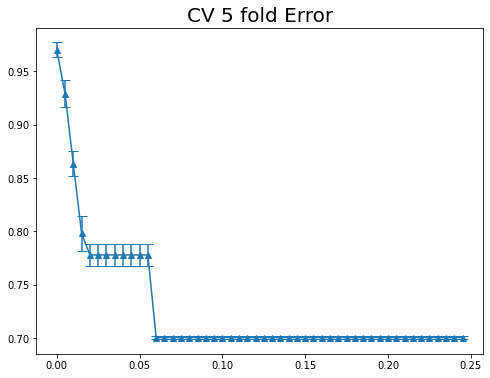

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.errorbar(tunner_car_t.cv_results_['param_ccp_alpha'], 
            tunner_car_t.cv_results_['mean_test_score'], 
            yerr=tunner_car_t.cv_results_['std_test_score'], 
            capsize=5,
            marker='^')
_=ax.set_title('CV 5 fold Error', fontsize=20)

#### Train validation

In [12]:
print(classification_report(y_train, y_tr_pred))

              precision    recall  f1-score   support

         acc       1.00      1.00      1.00       307
        good       1.00      1.00      1.00        55
       unacc       1.00      1.00      1.00       968
       vgood       1.00      1.00      1.00        52

    accuracy                           1.00      1382
   macro avg       1.00      1.00      1.00      1382
weighted avg       1.00      1.00      1.00      1382



#### Test validation

In [13]:
y_te_pred = tunner_car_t.predict(X_test)

In [14]:
print(classification_report(y_test, y_te_pred))

              precision    recall  f1-score   support

         acc       0.96      0.97      0.97        77
        good       0.93      0.93      0.93        14
       unacc       0.99      0.99      0.99       242
       vgood       1.00      1.00      1.00        13

    accuracy                           0.98       346
   macro avg       0.97      0.97      0.97       346
weighted avg       0.98      0.98      0.98       346



In [15]:
tunner_car_t.best_params_

{'ccp_alpha': 0.0}

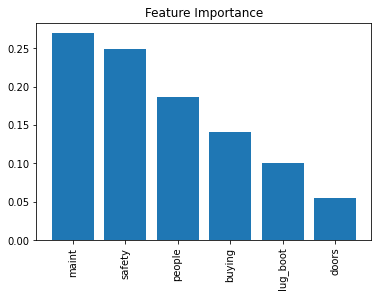

In [16]:
importances = tunner_car_t.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

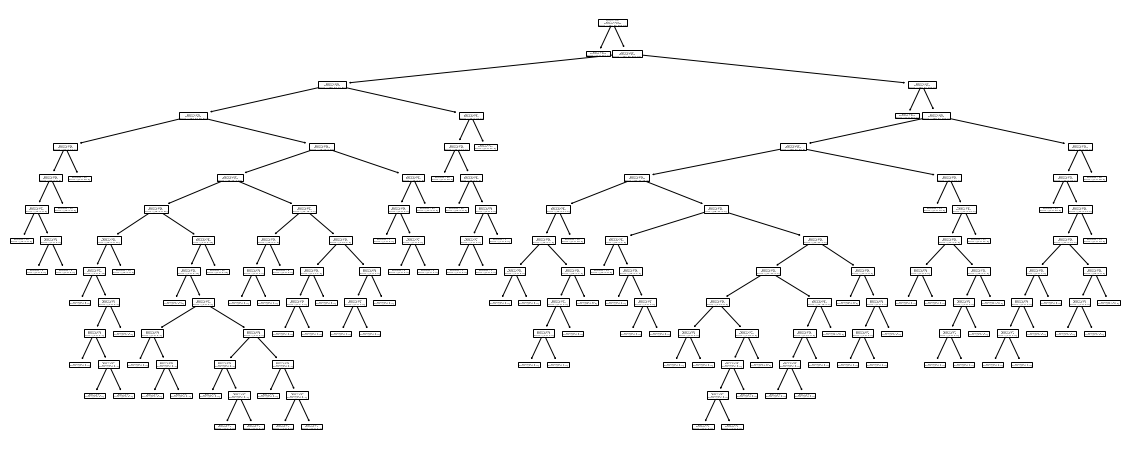

In [17]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111)
plot_tree(tunner_car_t.best_estimator_, ax=ax)
plt.show()

## Conclusiones car.data

- **ccp_alpha**: podemos ver que nuestro árbol es más complejo a medida que el alfa es menor. Valores mas grandes de ccp_alpha aumentan la cantidad de nodos podados. El número de nodos y la profundidad del árbol disminuyen a medida que el alfa aumenta. En nuestro caso el alfa seleccionado fue cero. Teniendo un un score de training en 1 y el de test en .98 podemos pensar que estamos sobreajustando nuestro modelo. Para solucionarlo podriamos intentar conseguir mas datos.

- **KFolds**: Con respecto a la diferencia entre StratifiedKFold y KFold podemos decir que el primero tiene en cuenta que cada fold debe tener la misma proporción de observaciones de determinada etiqueta, que en este caso fue la target. Kfold en cambio es un validador que divide de manera random el dataset para entrenar y testear. El StratifiedKFold es muy util para problemas de clasificación, ya que nos permite asegurarnos que cada division entre train/test va a tener siemrpe las variables target de las cuales el modelo debe aprender.

_____________________________

## aug_train.csv

In [18]:
df_aug = pd.read_csv(path_data / 'aug_train.csv',
                    )
df_aug.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### EDA

In [19]:
datatype = df_aug.dtypes
categorical = datatype[(datatype == 'object') | (datatype == 'category')].index.tolist()        

In [20]:
cat_plt = categorical.copy()
cat_plt.remove('city')

Ciudad

In [21]:
df_aug.city.value_counts().nlargest(10)

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
city_136     586
city_67      431
city_75      305
city_102     304
city_104     301
Name: city, dtype: int64

In [22]:
df_aug.city.nunique()

123

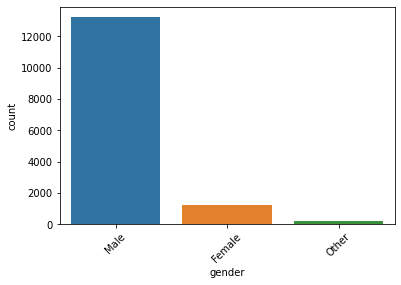

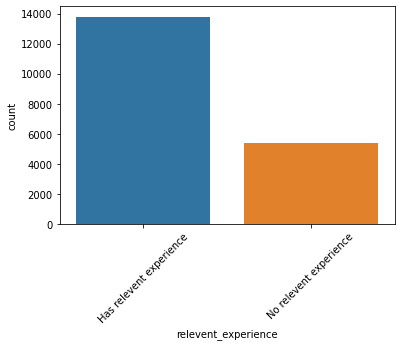

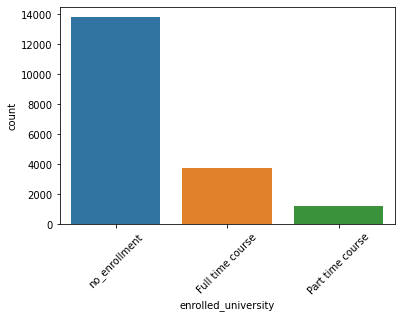

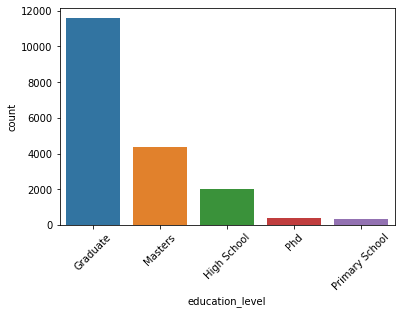

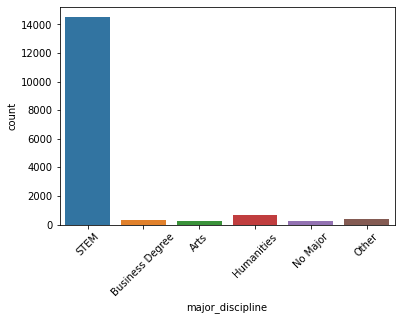

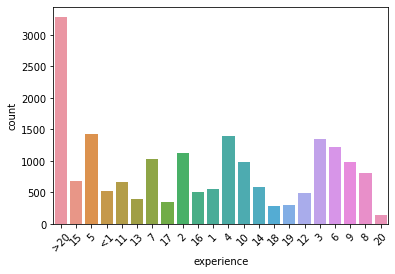

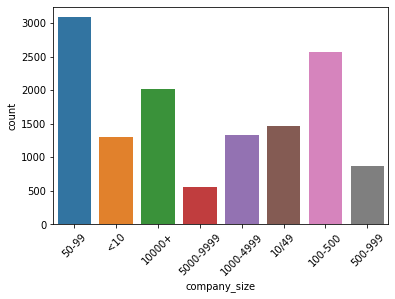

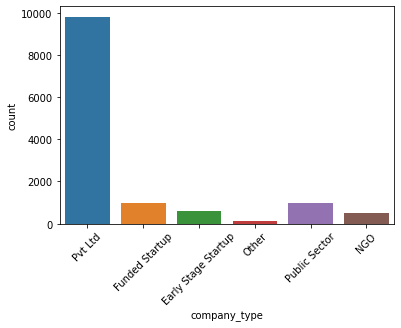

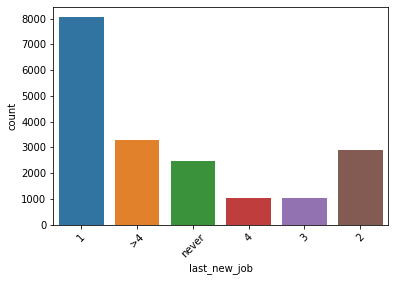

In [23]:
for col, i in zip(cat_plt, range(0, len(cat_plt), 1)):
    sns.countplot(data = df_aug, x = df_aug[col]) 
    plt.xticks(rotation=45)
    plt.show()

### Data preparation

In [24]:
X_aug = df_aug.drop(columns = ['target', 'city'], axis = 1)
y_aug = df_aug.target

Como utilizaremos arboles tenemos que cambiar las variables a numéricas

In [25]:
X_aug = pd.get_dummies(X_aug, columns=cat_plt)

In [26]:
X_aug.head(3)

,enrollee_id,city_development_index,training_hours,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,8949,0.920,36,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,29725,0.776,47,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,11561,0.624,83,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
fields = [x for x in df_aug.columns if x not in cat_plt]
fields.remove('city')
fields.remove('target')

#### Split

In [28]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_aug, y_aug,
                                                    test_size=0.2, 
                                                    random_state=17, 
                                                    stratify = y_aug)

In [29]:
scaled_tr = X_train_a.copy()
scaled_te = X_test_a.copy()

#### Escalamos los datos no dummies

In [30]:
sc = StandardScaler()

In [31]:
features_tr = scaled_tr[fields]
features_te = scaled_te[fields]

features_tr = sc.fit_transform(features_tr.values)
features_te = sc.transform(features_te.values)

In [32]:
scaled_tr[fields] = features_tr
scaled_te[fields] = features_te

#### Selección de parámetros

El parámetro que haremos variar en el grid search es el ccp_alpha que es un parámetro que nos da los alfas efectivos de los subarboles durante el pruning y que tambien las correspondientes impurezas. Estos valores de alfa pueden ser usados para prunear nuestro arbol de decisiones.

In [33]:
par = list(np.arange(0, .25, step=0.005))
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

tunner_aug_t = GridSearchCV(estimator=DecisionTreeClassifier(), 
                            param_grid={'ccp_alpha':par}, 
                            cv=cv)

#### Train

In [34]:
_=tunner_aug_t.fit(scaled_tr, y_train_a)

In [35]:
y_tr_pred_a = tunner_aug_t.predict(scaled_tr)

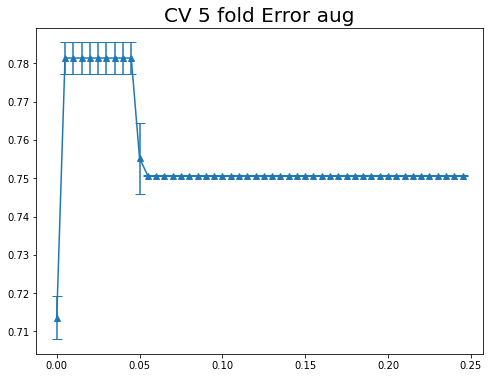

In [36]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.errorbar(tunner_aug_t.cv_results_['param_ccp_alpha'], 
            tunner_aug_t.cv_results_['mean_test_score'], 
            yerr=tunner_aug_t.cv_results_['std_test_score'], 
            capsize=5,
            marker='^')
_=ax.set_title('CV 5 fold Error aug', fontsize=20)

#### Train validation

In [37]:
print(classification_report(y_train_a, y_tr_pred_a))

              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86     11504
         1.0       0.59      0.42      0.49      3822

    accuracy                           0.78     15326
   macro avg       0.70      0.66      0.68     15326
weighted avg       0.76      0.78      0.77     15326



#### Test validation

In [38]:
y_te_pred_a = tunner_aug_t.predict(scaled_te)

In [39]:
print(classification_report(y_test_a, y_te_pred_a))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      2877
         1.0       0.60      0.43      0.50       955

    accuracy                           0.79      3832
   macro avg       0.71      0.67      0.68      3832
weighted avg       0.77      0.79      0.77      3832



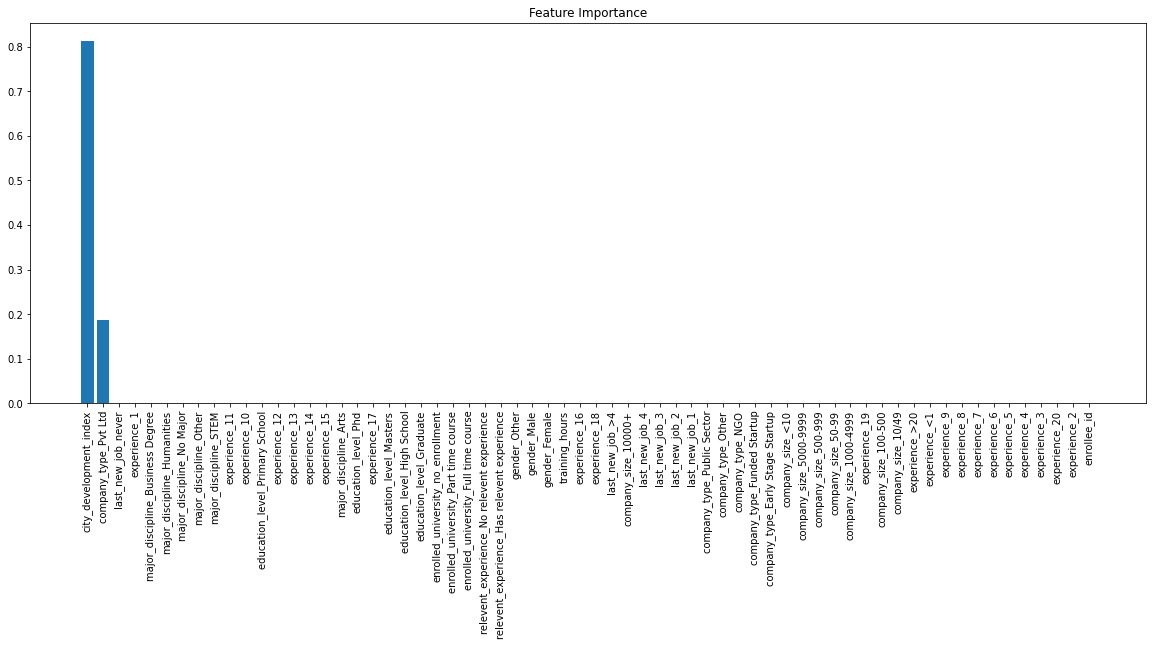

In [40]:
importances = tunner_aug_t.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
names = [scaled_tr.columns[i] for i in indices]

plt.figure(figsize = (20, 7))
plt.title("Feature Importance")
plt.bar(range(scaled_tr.shape[1]), importances[indices])
plt.xticks(range(scaled_tr.shape[1]), names, rotation=90)
plt.show()

In [41]:
tunner_aug_t.best_params_

{'ccp_alpha': 0.005}

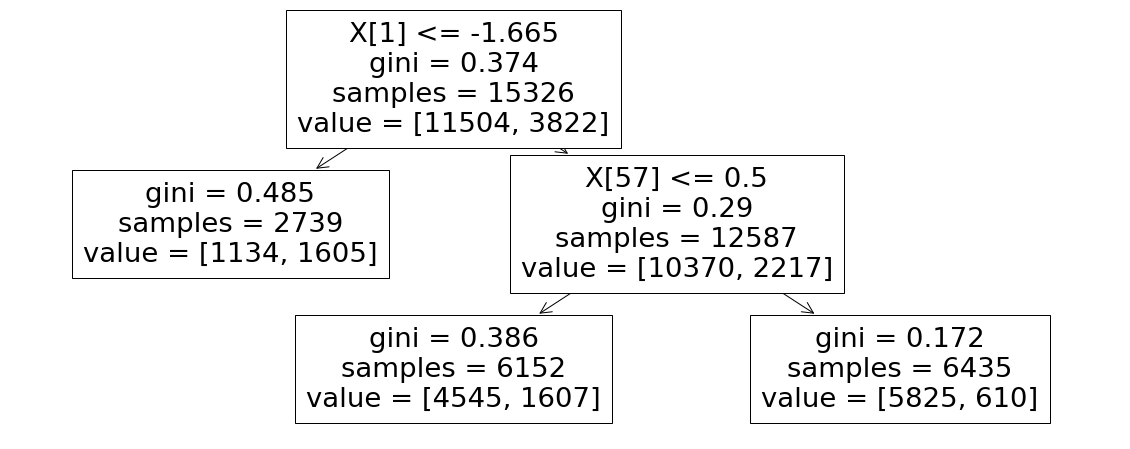

In [42]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111)
plot_tree(tunner_aug_t.best_estimator_, ax=ax)
plt.show()

### Conclusiones aug

- **ccp_alpha**: podemos ver que nuestro árbol es más complejo a medida que el alfa es menor. Valores mas grandes de ccp_alpha aumentan la cantidad de nodos podados. El número de nodos y la profundidad del árbol disminuyen a medida que el alfa aumenta. En nuestro caso el alfa seleccionado fue 0.005. A diferencia del caso anterior, si tenemos cierta penalización en nuestro árbol, a pesar de que es un número pequeño. Los scores de train (.78) y test (.79) son bastante similares, y como vemos obtuvimos un árbol pequeño por lo que no creo que haya sobreajuste.

- **KFolds**: Con respecto a la diferencia entre StratifiedKFold y KFold podemos decir que el primero tiene en cuenta que cada fold debe tener la misma proporción de observaciones de determinada etiqueta, que en este caso fue la target. Kfold en cambio es un validador que divide de manera random el dataset para entrenar y testear. El StratifiedKFold es muy util para problemas de clasificación, ya que nos permite asegurarnos que cada division entre train/test va a tener siemrpe las variables target de las cuales el modelo debe aprender.